In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("outputs/esri_with_polluted_heatday_coldday_hotspot.parquet")

In [3]:
df = df.drop(columns=["tmax","tmin","pm25"])

In [4]:
df.head()

wfday  heatday  coldday  polluted  hotspot
time       FIPS                                              
2005-12-31 1765.0  False    False    False     False    False
           1766.0  False    False    False     False    False
           1767.0  False    False    False     False    False
           1768.0  False    False    False     False    False
           1769.0  False    False    False     False    False

## Get time lag

In [48]:
def get_eves_time_lag(eve1, eve2):
    # get data subset with events
    hdf = df[df[eve1] | df[eve2]]
    hdf = hdf[[eve1, eve2]].reset_index()

    grouped_hdf = hdf.sort_values(['time']).groupby(["FIPS"])

    # sequence to day1 of event 1
    hdf['shift'] = grouped_hdf[eve1].shift(fill_value = False)
    # gets first day in a sequence of days
    hdf['eve1'] = np.where(
        ((hdf[eve1]==True) & (hdf['shift']==False)), 
        True,
        False
    )

    # sequence to day1 of event 2
    hdf['shift'] = grouped_hdf[eve2].shift(fill_value = False)
    # gets first day in a sequence of days
    hdf['eve2'] = np.where(
        (hdf[eve1]==True) & (hdf['shift']==False), 
        True,
        False
    )
    
    # subset for events
    hdf = hdf[hdf["eve1"] | hdf["eve2"]]

    # difference between consequentive events per location
    hdf['difference'] = hdf.sort_values(
        ['time']).groupby('FIPS')['time'].diff()
    hdf["difference"] = hdf["difference"].dt.days
    
    # add 0-days if eve1 and eve2 happen at the same time
    hdf['difference'] = np.where(
        (hdf["eve1"]==True) & (hdf["eve2"]==True), 
        0,
        hdf['difference']
    )
    
    # get only events where eve1 is first and eve2 is second 
    # or eve1&2 happen at the same time
    hdf[eve1+'_shift'] = hdf.groupby('FIPS')['eve1'].shift()
    hdf = hdf[(hdf['eve2'] & hdf[eve1+'_shift'])|
             (hdf['eve2'] & hdf['eve1'])]

    # cleanup
    hdf = hdf.drop(
        columns=['shift','eve1','eve2', eve1+'_shift'])
    return hdf

In [49]:
time_lag_dict = {}

for eve1 in ["wfday", "polluted", "heatday"]:
    for eve2 in ["wfday", "polluted", "heatday"]:
        if eve1 != eve2:
            temp = get_eves_time_lag(eve1, eve2)
            temp = temp[temp.difference < 15]
            
            a = eve1
            b = eve2
            if eve1 == "wfday":
                a = "wildfire"
            if eve2 == "wfday":
                b = "wildfire"
            if eve1 == "polluted":
                a = "pollution"
            if eve2 == "polluted":
                b = "pollution"
            name = a+" to "+b
            time_lag_dict[name] = temp

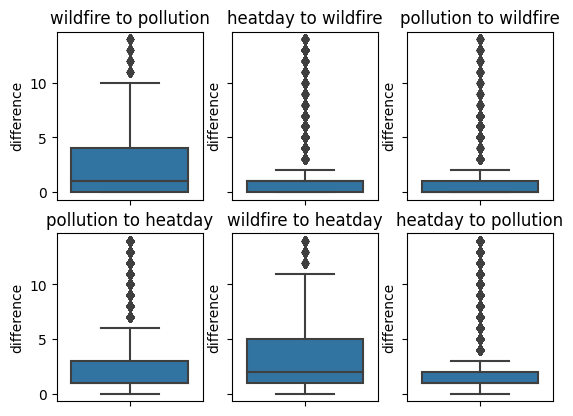

In [50]:
fig, axes = plt.subplots(2, 3, sharey=True)

for i, lab in zip(range(6), time_lag_dict.keys()):
    sns.boxplot(data=time_lag_dict[lab], y ="difference", ax=axes[i%2, i%3]).set(title=lab)

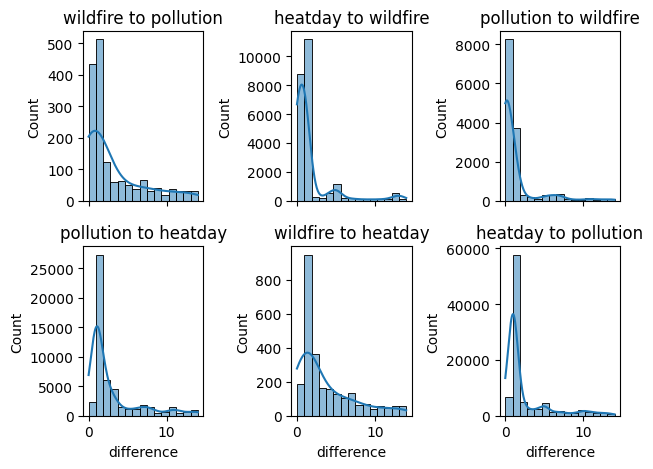

In [51]:
fig, axes = plt.subplots(2, 3, sharex=True)

for i, lab in zip(range(6), time_lag_dict.keys()):
    sns.histplot(
        time_lag_dict[lab], 
        x="difference", 
        bins=15, 
        ax=axes[i%2, i%3], 
        kde=True,
        kde_kws = {"bw_adjust":2}
    ).set(title=lab)
fig.tight_layout()

In [52]:
for i, lab in zip(range(6), time_lag_dict.keys()):
    print(lab + ": " + str(time_lag_dict[lab].difference.mean().round(2))+" days. Sample: "+
         str(len(time_lag_dict[lab])))

wildfire to pollution: 2.89 days. Sample: 1561
wildfire to heatday: 3.55 days. Sample: 2557
pollution to wildfire: 1.14 days. Sample: 13904
pollution to heatday: 2.92 days. Sample: 52150
heatday to wildfire: 1.55 days. Sample: 23612
heatday to pollution: 2.38 days. Sample: 89478


In [53]:
time_lag_dict["wildfire to pollution"].describe()

,FIPS,difference
count,1561.000000,1561.000000
mean,6266.878283,2.885330
std,2009.227793,3.797644
min,2037.000000,0.000000
25%,4091.000000,0.000000
50%,6134.000000,1.000000
75%,8370.000000,4.000000
max,9095.000000,14.000000


In [170]:
df = df.reset_index()

In [194]:
dfres = df.groupby("FIPS").resample('6M', on="time").sum()

In [172]:
dfres["total"] = dfres[["wfday","heatday","polluted"]].sum(axis=1)

In [197]:
dfres = dfres.drop(columns="FIPS")

In [176]:
temp = dfres.reset_index().groupby("FIPS")["total"].sum()

In [184]:
l = temp.sort_values().tail(5).index

In [198]:
dfres = dfres.reset_index()

In [199]:
dfres[dfres.FIPS.isin(l)].head()

,FIPS,time,index,wfday,heatday,coldday,polluted,hotspot
23727,2496.0,2005-12-31,719,0,0,0,0,0
23728,2496.0,2006-06-30,148220900,0,11,21,24,0
23729,2496.0,2006-12-31,452595380,0,24,23,30,0
23730,2496.0,2007-06-30,742211315,0,3,28,30,0
23731,2496.0,2007-12-31,1056430940,0,22,24,41,0


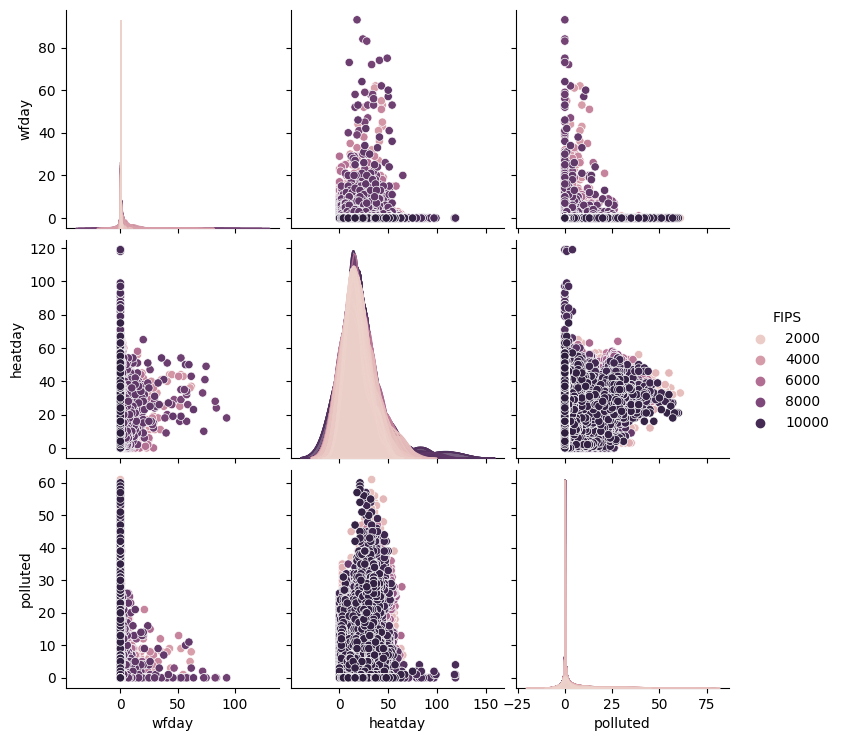

In [201]:
sns.pairplot(dfres[["FIPS","wfday","heatday","polluted"]], hue="FIPS")